In [1]:
import torch 
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as transforms
import numpy as np

C:\Users\11515\Desktop\PyTorch\data\FashionMNIST\raw
    C:/Users/11515/Desktop/Pytorch/data/

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='C:/Users/11515/Desktop/Pytorch/data/', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='C://Users/11515/Desktop/Pytorch/data/', train=False, download=False, transform=transforms.ToTensor())

C:/Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\training.pt C:/Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\test.pt
C://Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\training.pt C://Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\test.pt


In [3]:
print(len(mnist_train),len(mnist_test))

60000 10000


In [3]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

### data loader

In [4]:
import sys

In [5]:
batch_size=256
if sys.platform.startswith('win'):
    num_workers=0
else:
    num_workers=4
train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,
                                      num_workers=num_workers)
test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,
                                      num_workers=num_workers)

In [8]:
import time
start=time.time()
for x,y in train_iter:
    continue
print('%.2f sec'%(time.time()-start))

6.09 sec


In [7]:
import random

In [8]:
random.randint(0,len(train_iter))

23

In [10]:
len(mnist_train)

60000

In [7]:
from IPython import display
from matplotlib import pyplot as plt

def use_svg_display():
    display.set_matplotlib_formats('svg')
def show_fashion_mnist(images,labels):
    _,figs=plt.subplots(1,len(images),figsize=(12,12))
    for f,img,lbl in zip(figs,images,labels):
        f.imshow(img.view((28,28)).numpy(),cmap='gray')
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

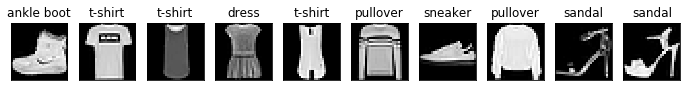

In [11]:
X=[mnist_train[i][0].mul(255) for i in range(10)]
y=[mnist_train[i][1] for i in range(10)]
show_fashion_mnist(X,get_fashion_mnist_labels(y))

### softmax implement from scratch

pytorch 中对维度的操作，可以只对其中同一列（dim=0）或同一行（dim=1）的元素求和，并在结果中保留行和列这两个维度（keepdim=True）

In [12]:
X=torch.tensor([[1,2,3],[4,5,6]])
print(X.sum(dim=0,keepdim=True))
print(X.sum(dim=1,keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [2]:
def softmax(X):
    X_exp=X.exp()
    partition=X_exp.sum(dim=1,keepdim=True)
    return X_exp/partition


softmax([10.0, 10.1, 10.2])


softmax([-100, -101, -102])


softmax([-2 -1, 0])


softmax([1000, 1010, 1020])
softmax 是将数据的偏离转化为概率值，只要步长一致，计算结果就一致，与倍数无关

In [14]:
print(softmax(torch.FloatTensor([[100, 101, 102]])))
print(softmax(torch.FloatTensor([[10.0, 10.1, 10.2]])))
print(softmax(torch.FloatTensor([[2,4,6]])))
print(softmax(torch.FloatTensor([[10,12,14]])))
print(softmax(torch.FloatTensor([[1000, 1010, 1020]])))

tensor([[nan, nan, nan]])
tensor([[0.3006, 0.3322, 0.3672]])
tensor([[0.0159, 0.1173, 0.8668]])
tensor([[0.0159, 0.1173, 0.8668]])
tensor([[nan, nan, nan]])


In [ ]:
2=

In [14]:
num_inputs=28**2
num_outputs=10
W=torch.tensor(np.random.normal(0,0.01,size=(num_inputs,num_outputs)),dtype=torch.float)
b=torch.zeros(num_outputs,dtype=torch.float)

In [15]:
def net(X):
    return softmax(torch.mm(X.view((-1,num_inputs)),W)+b)

In [16]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat.gather(1,y.view(-1,1)))

In [17]:
def accuracy(y_hat,y):
    return (y_hat.argmax(dim=1)==y).float().mean().item()

In [47]:
def evaluate_acc(data_iter,net):
    acc_sum,n=0.0,0
    for X,y in data_iter:
        acc_sum+=(net(X).argmax(dim=1)==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n


In [44]:
def train_softmax_classification_net(net,train_iter,test_iter,loss,num_epochs,batch_size,
          lr=0.001,params=None,optimizer=None):
    for epoch in range(num_epochs):
        train_loss_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            y_hat=net(X)
            l=loss(y_hat,y).sum()
            
            # clear gradient
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            # bp
            l.backward()
            if optimizer is None:
                for param in params:
                    param.data-=lr*param.grad/batch_size
            else:
                optimizer.step()
            
            train_loss_sum+=l.item()
            train_acc_sum+= (y_hat.argmax(dim=1) == y).sum().item()
            n+=y.shape[0]
        test_acc=evaluate_acc(test_iter,net)
        
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_loss_sum / n, train_acc_sum / n, test_acc))


### using pytorch module to implement softmax classificatio model

In [26]:
num_inputs=28**2
num_outputs=10

class Linear_Softmax_Net(nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super().__init__()
        self.linear=nn.Linear(num_inputs,num_outputs)
    def forward(self,X):
        return self.linear(X.view(x.shape[0],-1))# x shape: (batch, 1, 28, 28)

net=Linear_Softmax_Net(num_inputs,num_outputs)

In [27]:
print(net)

Linear_Softmax_Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [37]:
#Flatten Layer
class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.view(X.shape[0],-1)

### define net easier

In [38]:
from collections import OrderedDict

net=nn.Sequential(
    OrderedDict([
        ('flatten',FlattenLayer()),
        ('linear',nn.Linear(num_inputs,num_outputs))
    ])
)

In [30]:
print(net)

Sequential(
  (flatten): FlattenLayer()
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [39]:
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [33]:
type(net)

torch.nn.modules.container.Sequential

In [49]:
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)


In [50]:
num_epochs = 5
train_softmax_classification_net(net, train_iter, test_iter, loss, num_epochs, 
              batch_size, None, None, optimizer)

epoch 1, loss 0.0019, train acc 0.837, test acc 0.824
epoch 2, loss 0.0018, train acc 0.842, test acc 0.825
epoch 3, loss 0.0017, train acc 0.849, test acc 0.841
epoch 4, loss 0.0017, train acc 0.850, test acc 0.836
epoch 5, loss 0.0017, train acc 0.851, test acc 0.828


### save model

In [54]:
torch.save(net.state_dict(), './model_weight.pth')

### load model parameters

In [55]:
net.load_state_dict(torch.load('./Fashion_Mnist/Fashion_Mnist_Softmax_Classification.pkl'))

<All keys matched successfully>

### Testing my net class

In [26]:
import os
import random
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.functional as tf
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import init

# To build a simple net with a flatten and a linear layer to classify
# Fashion_Mnist dataset
# please ensure that you have already downloaded the original dataset

def get_fashion_mnist_labels(labels):
    """return true labels according to y_label"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def dataload(path,batch_size,num_workers=None):
    """
    path:upper folder path which contains datasets files
    batch_size:number of one mini_batch
    num_worker: CPU workers when loading image
    return: two iterable object: train_set and test_set
    """
    # build torch.dataset object
    mnist_train = torchvision.datasets.FashionMNIST(root=path, train=True, 
                                            download=True, transform=transforms.ToTensor())
    mnist_test = torchvision.datasets.FashionMNIST(root=path, train=False, 
                                            download=True, transform=transforms.ToTensor())
    # set num_workeres
    if num_workers is None:
        if sys.platform.startswith('win'):
            num_workers=0
        else:
            num_workers=4
    # build iterable Dataloader object
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,
                                    num_workers=num_workers)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,
                                    num_workers=num_workers)
    return train_iter,test_iter,mnist_train,mnist_test


#Flatten Layer
class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.view(X.shape[0],-1)


class Linear_Softmax_Net:
    def __init__(self,path,num_workers,num_inputs,num_outputs,learning_rate,batch_size):
        # using sequential to build model easier
        self.net=nn.Sequential(
            OrderedDict([
                ('flatten',FlattenLayer()),
                # insert any layer you need
                ('linear',nn.Linear(num_inputs,num_outputs))
            ])
        )
        # initialize model default parameters
        init.normal_(self.net.linear.weight,mean=0,std=0.01)
        init.constant_(self.net.linear.bias,val=0)
        # load data
        assert os.path.exists(path)
        self.train_iter,self.test_iter,self.mnist_train,_=dataload(path,batch_size,num_workers)
        self.loss=nn.CrossEntropyLoss()
        self.optimizer=torch.optim.SGD(self.net.parameters(),lr=learning_rate,momentum=0.9)
    
    def train(self,epochs,ver_gap,verbose=True,test=True):
        for epoch in range(1,epochs+1):
            train_loss_sum,train_acc_sum,n=0.0,0.0,0
            test_acc=0.0
            for X,y in self.train_iter:
                y_hat=self.net(X)
                l=self.loss(y_hat,y).sum()
                
                # clear gradient
                self.optimizer.zero_grad()
                
                # bp
                l.backward()
                self.optimizer.step()
                
                train_loss_sum+=l.item()
                train_acc_sum+= (y_hat.argmax(dim=1) == y).sum().item()
                n+=y.shape[0]
            if test:
                test_acc=self.evaluate_acc(self.test_iter,self.net)
            if epoch%ver_gap==0 and verbose:
                print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
                    % (epoch, train_loss_sum / n, train_acc_sum / n, test_acc))
    
    def evaluate_acc(self,data_iter,net):
        acc_sum,n=0.0,0
        for X,y in data_iter:
            acc_sum+=(self.net(X).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
        return acc_sum/n

    def save_model(self,model_path):
        assert os.path.exists(model_path)
        torch.save(self.net.state_dict(),model_path)
        print('Saving model successfully')
    
    def load_model_weight(self,model_path):
        assert os.path.exists(model_path)
        self.net.load_state_dict(torch.load(model_path))
        print('Loading model successfully')
    
    # def cross_entropy(self,y_hat,y):
    #     return -torch.log(y_hat.gather(1,y.view(-1,1)))

    def softmax(self,X):
        X_exp=X.exp()
        partition=X_exp.sum(dim=1,keepdim=True)
        return X_exp/partition

    def show_fashion_mnist(self,num):
        # 缺少随机选取的函数
        images,lbls=[],[]
        for img in self.mnist_train:
            if num>0:
                images.append(img[0])
                lbls.append(img[1])
                num-=1
            else: break
        #print(lbls)
        labels=get_fashion_mnist_labels(lbls)
        
        _,figs=plt.subplots(1,len(images),figsize=(12,12))
        for f,img,lbl in zip(figs,images,labels):
            f.imshow(img.view((28,28)).numpy(),cmap='gray')
            f.set_title(lbl)
            f.axes.get_xaxis().set_visible(False)
            f.axes.get_yaxis().set_visible(False)


In [27]:
net=Linear_Softmax_Net(path='C:/Users/11515/Desktop/Pytorch/data/',num_workers=0,
                      num_inputs=28**2,num_outputs=10,learning_rate=0.01,batch_size=256)

Processing...
Done!
C:/Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\training.pt C:/Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\test.pt
Processing...
Done!
C:/Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\training.pt C:/Users/11515/Desktop/Pytorch/data/FashionMNIST\processed\test.pt


[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


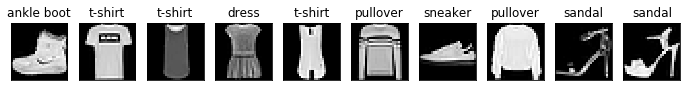

In [28]:
net.show_fashion_mnist(10)

In [29]:
net.train(5,1)

epoch 2, loss 0.0031, train acc 0.742, test acc 0.792
epoch 3, loss 0.0022, train acc 0.816, test acc 0.813
epoch 4, loss 0.0020, train acc 0.827, test acc 0.818
epoch 5, loss 0.0019, train acc 0.834, test acc 0.822
epoch 6, loss 0.0019, train acc 0.838, test acc 0.825
